<a href="https://colab.research.google.com/github/dbeniteze/ResNets/blob/master/mod_resnet_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip3 install keras==2.3.1
%tensorflow_version 2.x
import tensorflow as tf
#device_name = tf.test.gpu_device_name()
#if device_name != '/device:GPU:0':
#  raise SystemError('GPU device not found')
#print('Found GPU at: {}'.format(device_name))

     |████████████████████████████████| 378kB 34.3MB/s 
  Found existing installation: Keras 2.2.5
    Uninstalling Keras-2.2.5:
      Successfully uninstalled Keras-2.2.5
TensorFlow 2.x selected.


In [0]:
from keras import backend as K
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout, Reshape
from keras.layers import Flatten, BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from matplotlib import pyplot as plt
import numpy as np
# load data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
# reshape to be [samples][width][height][channels]
X_train = X_train.reshape((X_train.shape[0], 32, 32, 3)).astype('float32')
X_test = X_test.reshape((X_test.shape[0], 32, 32, 3)).astype('float32')
# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255
# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)


     8192/170498071 [..............................] - ETA: 6:58

Using TensorFlow backend.


170500096/170498071 [==============================] - 2s 0us/step


In [0]:
import keras
from keras.models import Model
from keras.layers import Dense, Flatten, BatchNormalization
from keras.layers import Conv2D, Input, Activation, AveragePooling2D
from keras.optimizers import Adam
from keras.regularizers import l2



def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='elu',            #modificado
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
            x = Dropout(0.05)(x)          #añadido
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
            x = Dropout(0.05)(x)          #añadido
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x



def resnet_v2(input_shape, depth, num_classes=10):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'elu'           #modificado
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('elu')(x)           #modificado
    x = AveragePooling2D(pool_size=8)(x)
    x = Dropout(0.05)(x)          #añadido    
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


    
model = resnet_v2(input_shape=(32,32,3), depth=56)
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])
model.summary()


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_117 (Conv2D)             (None, 32, 32, 16)   448         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_111 (BatchN (None, 32, 32, 16)   64          conv2d_117[0][0]                 
__________________________________________________________________________________________________
dropout_111 (Dropout)           (None, 32, 32, 16)   0           batch_normalization_111[0][0]    
____________________________________________________________________________________________

In [0]:
# Fit the model
modelo = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=75, batch_size=32)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
 
print("Error: %.2f%%" % (100-scores[1]*100))

Epoch 1/100
782/782 [==============================] - 258s 330ms/step - loss: 2.3077 - accuracy: 0.4427 - val_loss: 2.0860 - val_accuracy: 0.4987
Epoch 2/100
782/782 [==============================] - 238s 304ms/step - loss: 1.6765 - accuracy: 0.5666 - val_loss: 1.6006 - val_accuracy: 0.6030
Epoch 3/100
782/782 [==============================] - 237s 303ms/step - loss: 1.4534 - accuracy: 0.6124 - val_loss: 1.5157 - val_accuracy: 0.5850
Epoch 4/100
782/782 [==============================] - 237s 303ms/step - loss: 1.3152 - accuracy: 0.6442 - val_loss: 1.3462 - val_accuracy: 0.6463
Epoch 5/100
782/782 [==============================] - 236s 302ms/step - loss: 1.2223 - accuracy: 0.6705 - val_loss: 1.4322 - val_accuracy: 0.6174
Epoch 6/100
782/782 [==============================] - 237s 303ms/step - loss: 1.1439 - accuracy: 0.6940 - val_loss: 1.1589 - val_accuracy: 0.7083
Epoch 7/100
782/782 [==============================] - 238s 305ms/step - loss: 1.0832 - accuracy: 0.7113 - val_loss: 1

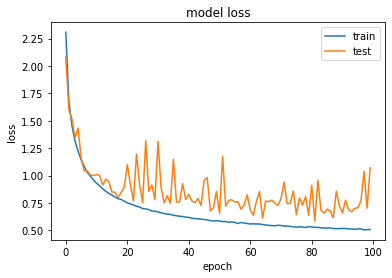

Error: 24.84%


In [0]:
from keras.preprocessing.image import ImageDataGenerator

# Data augmentation
datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=15,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

# Compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(X_train)

# Fit the model on the batches generated by datagen.flow().
modelo = model.fit_generator(datagen.flow(X_train, y_train, batch_size=64),
                        validation_data=(X_test, y_test),
                        epochs=100, verbose=1)
    

scores = model.evaluate(X_test, y_test, verbose=0)


plt.plot(modelo.history['loss'])
plt.plot(modelo.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

print("Error: %.2f%%" % (100-scores[1]*100))